<a href="https://colab.research.google.com/github/vijayswarnkar/codes/blob/master/Pretrained%20and%20Finetuned%20Models/1.%20domain-adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the necessary libraries

In [ ]:
import torch
import torch.utils.data
from torchvision import transforms
from torchvision.datasets import CIFAR10, FashionMNIST
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
# !pip install torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# Setup the Data Class (CIFAR10 & FashionMNIST)
Always create classes for major modules. This will make your project modular, allowing you to switch different, in this case, datasets and test your model.
Out of all the advantages of this coding habit, one advantage of creating multiple objecs of the data class is that it allows you to perform ensemble learning.

In [ ]:
class DataModule():
    def __init__(self, batch_size, fmnist=False):
        super().__init__()
        self.batch_size = batch_size
        self.fmnist = fmnist
        # We define some augmentations that we would like to apply during training
        self.train_transform = transforms.Compose([

            transforms.Resize(256),
            transforms.RandomCrop(224, 4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # During validation we need to only normalize and resize
        self.val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        if self.fmnist:
            self.train_transform = transforms.Compose([
                transforms.transforms.Grayscale(3),
                self.train_transform
            ])
            self.val_transform = transforms.Compose([
                transforms.transforms.Grayscale(3),
                self.val_transform
            ])

    # This function sets up our datasets
    # which includes downloading and applying the augmentations
    def prepare_data(self):
        if self.fmnist:
            self.train_set = FashionMNIST(root='./data', train=True, download=True, transform=self.train_transform)
            self.val_set = FashionMNIST(root='./data', train=False, download=True, transform=self.val_transform)
        else:
            self.train_set = CIFAR10(root='./data', train=True, download=True, transform=self.train_transform)
            self.val_set = CIFAR10(root='./data', train=False, download=True, transform=self.val_transform)

    # This functions sets up the data loaders
    def setup(self):
        self.train_data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.val_data_loader = torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)

    # This is simply a getter function for the training data loader
    def train_dataloader(self, prune=True):
        return self.train_data_loader

    # This is simply a getter function for the validation data loader
    def val_dataloader(self):
        return self.val_data_loader

# Setup the Model Class
Here we will define the model, its forward pass and its behaviour during each training/validation iteration

In [ ]:
class DLModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True, num_unfreeze_layers=0):
        super().__init__()
        # If you want to use the imagenet pretrained weights
        if pretrained:
            self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
            # We freeze the entire model
            self.backbone.requires_grad_ = False
            # If you want to unfreeze some of the layers, then
            if num_unfreeze_layers > 0:
                # First find number of layers
                num_layers = 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        num_layers+=1
                # Following which unfreeze the last set of layers
                start_unfreezing_counter, counter = num_layers - num_unfreeze_layers, 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter+=1
                    if counter >= start_unfreezing_counter:
                        module.requires_grad_ = True
        # Otherwise just initialize the network from scratch
        else:
            self.backbone = resnet18(weights=None)
            self.backbone.requires_grad_ = True
        # The resnet model comes with a 1000 neuron final layer for the imagenet dataset
        self.backbone.fc = torch.nn.Sequential(
            torch.nn.Linear(512, num_classes)
        )
        self.backbone.fc.requires_grad_ = True
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()
        # Define the metrics
        self.train_acc1, self.val_acc1 = Accuracy(task="multiclass", num_classes=num_classes), Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc5, self.val_acc5 = Accuracy(task="multiclass", num_classes=num_classes, top_k=5), Accuracy(task="multiclass", num_classes=num_classes, top_k=5)

    # This function sets up the optimizer and scheduler that we will use
    def configure_optimizers(self, lr, momentum, max_epochs):
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs)

    # This defines the behaviour of our model during the forward pass
    # Based on the defined behaviour, PyTorch sets up the backward pass
    def forward(self, x):
        out = self.backbone(x)
        return out

    # This function describes model behaviour per iteration during training
    def training_step(self, x, y):
        self.optimizer.zero_grad()
        preds = self.forward(x)
        self.train_acc1.update(preds, y)
        self.train_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    # Once the epoch is complete, we can call this function for inspecting the model's performance
    def on_training_epoch_end(self, loss, epoch):
        acc1, acc5 = self.train_acc1.compute().item(), self.train_acc5.compute().item()
        print(f"Epoch No: {epoch+1}\nTraining Loss: {loss}\n Training Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function describes model behaviour per iteration during validation
    def validation_step(self, x, y):
        preds = self.forward(x)
        self.val_acc1.update(preds, y)
        self.val_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        return loss.item()

    # Once the validation iterations are complete, we can call this function for inspecting the model's performance
    def on_validation_epoch_end(self, loss, epoch):
        acc1, acc5 = self.val_acc1.compute().item(), self.val_acc5.compute().item()
        print(f"Validation Loss: {loss}\nValidation Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function resets the metrics so that new results can be calculated for the next epoch
    def reset_metrics(self):
        self.train_acc1.reset(), self.train_acc5.reset()
        self.val_acc1.reset(), self.val_acc5.reset()

# Putting it all together for CIFAR10
We first define some static and global variables

In [ ]:
# First define some static variables
num_classes = 10
num_epochs = 10
batch_size = 128
# Fine-tuning and training from scratch require different sets of learning rates
lr = 0.001
momentum = 0.9
device = torch.device("cuda")


# Define the data
data_module = DataModule(batch_size=batch_size)
data_module.prepare_data()
data_module.setup()
train_loader, val_loader = data_module.train_dataloader(), data_module.val_dataloader()

# This variable will be used to save the per-epoch validation accuracy
cifar10_val_acc = list()
# This variable will be used to save the per-epoch training loss
cifar10_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=0).to(device)
model.configure_optimizers(lr=lr, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    cifar10_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    cifar10_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 391/391 [03:40<00:00,  1.77it/s]


Epoch No: 1
Training Loss: 0.720007896042236
 Training Accuracy: 0.7735999822616577 (Top-1)	  0.9698600172996521 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Validation Loss: 0.3301464526713649
Validation Accuracy: 0.8934999704360962 (Top-1)	  0.9975000023841858 (Top-5)


100%|██████████| 391/391 [03:53<00:00,  1.68it/s]


Epoch No: 2
Training Loss: 0.2836257130898478
 Training Accuracy: 0.907039999961853 (Top-1)	  0.9981799721717834 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Validation Loss: 0.23044113795968552
Validation Accuracy: 0.9229000210762024 (Top-1)	  0.9987000226974487 (Top-5)


100%|██████████| 391/391 [03:54<00:00,  1.67it/s]


Epoch No: 3
Training Loss: 0.21565367353846654
 Training Accuracy: 0.929099977016449 (Top-1)	  0.9988800287246704 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Validation Loss: 0.20475289961205254
Validation Accuracy: 0.9304999709129333 (Top-1)	  0.9990000128746033 (Top-5)


100%|██████████| 391/391 [03:53<00:00,  1.68it/s]


Epoch No: 4
Training Loss: 0.17834352667603043
 Training Accuracy: 0.940559983253479 (Top-1)	  0.9993000030517578 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Validation Loss: 0.1771709782696223
Validation Accuracy: 0.9399999976158142 (Top-1)	  0.9997000098228455 (Top-5)


100%|██████████| 391/391 [03:52<00:00,  1.68it/s]


Epoch No: 5
Training Loss: 0.1537219980717315
 Training Accuracy: 0.9490200281143188 (Top-1)	  0.9994199872016907 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Validation Loss: 0.17271177253768413
Validation Accuracy: 0.9394000172615051 (Top-1)	  0.9991999864578247 (Top-5)


100%|██████████| 391/391 [03:53<00:00,  1.67it/s]


Epoch No: 6
Training Loss: 0.13692348439941932
 Training Accuracy: 0.9545199871063232 (Top-1)	  0.9994999766349792 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Validation Loss: 0.16431478990972798
Validation Accuracy: 0.942799985408783 (Top-1)	  0.9997000098228455 (Top-5)


100%|██████████| 391/391 [03:52<00:00,  1.68it/s]


Epoch No: 7
Training Loss: 0.11769590747859472
 Training Accuracy: 0.9614199995994568 (Top-1)	  0.9997400045394897 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Validation Loss: 0.15577758990133864
Validation Accuracy: 0.9466999769210815 (Top-1)	  0.9995999932289124 (Top-5)


100%|██████████| 391/391 [03:28<00:00,  1.88it/s]


Epoch No: 8
Training Loss: 0.10708374928806902
 Training Accuracy: 0.9646199941635132 (Top-1)	  0.9997000098228455 (Top-5)


100%|██████████| 79/79 [00:18<00:00,  4.26it/s]


Validation Loss: 0.14634851724663867
Validation Accuracy: 0.9495999813079834 (Top-1)	  0.9995999932289124 (Top-5)


100%|██████████| 391/391 [04:30<00:00,  1.45it/s]


Epoch No: 9
Training Loss: 0.09339188563797023
 Training Accuracy: 0.9692800045013428 (Top-1)	  0.9998000264167786 (Top-5)


100%|██████████| 79/79 [01:01<00:00,  1.28it/s]


Validation Loss: 0.14621011695907085
Validation Accuracy: 0.9513999819755554 (Top-1)	  0.9997000098228455 (Top-5)


100%|██████████| 391/391 [7:03:01<00:00, 64.91s/it]      


Epoch No: 10
Training Loss: 0.0839331375001489
 Training Accuracy: 0.9729999899864197 (Top-1)	  0.9998599886894226 (Top-5)


100%|██████████| 79/79 [00:18<00:00,  4.23it/s]

Validation Loss: 0.14245389293454871
Validation Accuracy: 0.9506999850273132 (Top-1)	  0.9997000098228455 (Top-5)


# Putting it all together for FashionMNIST
We first define some static and global variables

In [ ]:
# First define some static variables
num_classes = 10
num_epochs = 10
batch_size = 128
# Fine-tuning and training from scratch require different sets of learning rates
lr = 0.001
momentum = 0.9
device = torch.device("cuda")


# Define the data
data_module = DataModule(batch_size=batch_size, fmnist=True)
data_module.prepare_data()
data_module.setup()
train_loader, val_loader = data_module.train_dataloader(), data_module.val_dataloader()

# This variable will be used to save the per-epoch validation accuracy
mnist_val_acc = list()
# This variable will be used to save the per-epoch training loss
mnist_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=0).to(device)
model.configure_optimizers(lr=lr, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    mnist_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    mnist_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 26421880/26421880 [00:09<00:00, 2731805.77it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 196882.64it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3225742.18it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5154518.26it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 469/469 [04:15<00:00,  1.83it/s]


Epoch No: 1
Training Loss: 0.5466303225201584
 Training Accuracy: 0.8179333209991455 (Top-1)	  0.9843833446502686 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Validation Loss: 0.3509441169002388
Validation Accuracy: 0.8772000074386597 (Top-1)	  0.9983999729156494 (Top-5)


100%|██████████| 469/469 [04:10<00:00,  1.87it/s]


Epoch No: 2
Training Loss: 0.2902119063428724
 Training Accuracy: 0.8976500034332275 (Top-1)	  0.9985499978065491 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Validation Loss: 0.3185345604072643
Validation Accuracy: 0.8855999708175659 (Top-1)	  0.9988999962806702 (Top-5)


100%|██████████| 469/469 [04:10<00:00,  1.87it/s]


Epoch No: 3
Training Loss: 0.2436713809048189
 Training Accuracy: 0.913183331489563 (Top-1)	  0.9987833499908447 (Top-5)


100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Validation Loss: 0.27538530905789965
Validation Accuracy: 0.902899980545044 (Top-1)	  0.9988999962806702 (Top-5)


100%|██████████| 469/469 [04:00<00:00,  1.95it/s]


Epoch No: 4
Training Loss: 0.2159558549237404
 Training Accuracy: 0.9224833250045776 (Top-1)	  0.9991666674613953 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Validation Loss: 0.26192916514752784
Validation Accuracy: 0.9067999720573425 (Top-1)	  0.9991000294685364 (Top-5)


100%|██████████| 469/469 [04:03<00:00,  1.92it/s]


Epoch No: 5
Training Loss: 0.2006581279673556
 Training Accuracy: 0.928516685962677 (Top-1)	  0.9993500113487244 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


Validation Loss: 0.2693555153246167
Validation Accuracy: 0.9031000137329102 (Top-1)	  0.9987999796867371 (Top-5)


100%|██████████| 469/469 [04:06<00:00,  1.90it/s]


Epoch No: 6
Training Loss: 0.18597634516354564
 Training Accuracy: 0.9337833523750305 (Top-1)	  0.9995166659355164 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Validation Loss: 0.2419285778003403
Validation Accuracy: 0.9138000011444092 (Top-1)	  0.9990000128746033 (Top-5)


100%|██████████| 469/469 [04:02<00:00,  1.93it/s]


Epoch No: 7
Training Loss: 0.17610192673801106
 Training Accuracy: 0.9374833106994629 (Top-1)	  0.9995999932289124 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


Validation Loss: 0.24860934422740452
Validation Accuracy: 0.9111999869346619 (Top-1)	  0.9994000196456909 (Top-5)


100%|██████████| 469/469 [04:01<00:00,  1.95it/s]


Epoch No: 8
Training Loss: 0.16527478234060028
 Training Accuracy: 0.9409666657447815 (Top-1)	  0.9995666742324829 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Validation Loss: 0.2231006420488599
Validation Accuracy: 0.9222999811172485 (Top-1)	  0.9994000196456909 (Top-5)


100%|██████████| 469/469 [04:04<00:00,  1.92it/s]


Epoch No: 9
Training Loss: 0.15564770628013083
 Training Accuracy: 0.9453333616256714 (Top-1)	  0.9996333122253418 (Top-5)


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


Validation Loss: 0.216572385988658
Validation Accuracy: 0.9247999787330627 (Top-1)	  0.9993000030517578 (Top-5)


100%|██████████| 469/469 [04:13<00:00,  1.85it/s]


Epoch No: 10
Training Loss: 0.14974255422984106
 Training Accuracy: 0.9468166828155518 (Top-1)	  0.9997666478157043 (Top-5)


100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

Validation Loss: 0.22030502435150026
Validation Accuracy: 0.9211999773979187 (Top-1)	  0.9994999766349792 (Top-5)


# Comparisons
Now that we have evaluated the models for two different datasets, let us compare them
We expect that the performance of ResNet18 on MNIST should be considerably worse than CIFAR10 due to reduced domain adaptability

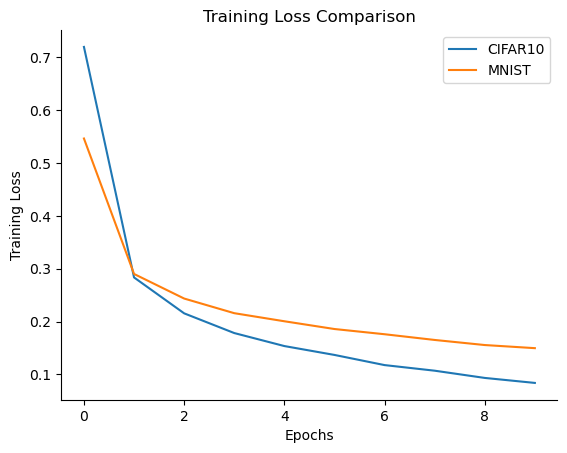

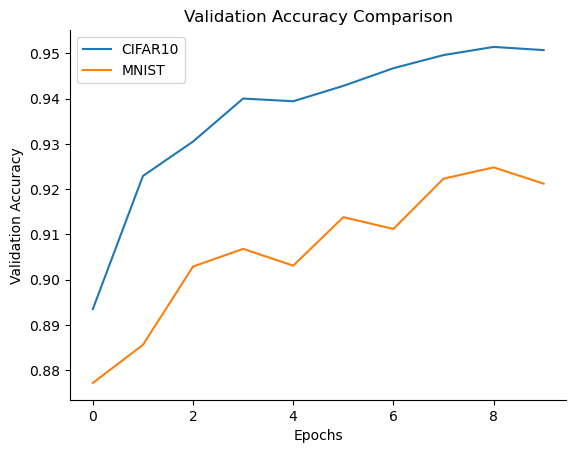

In [ ]:
# Comparing the Training loss per epoch
sns.lineplot(x=np.arange(len(cifar10_train_loss)), y=cifar10_train_loss, label="CIFAR10")
sns.lineplot(x=np.arange(len(mnist_train_loss)), y=mnist_train_loss, label="MNIST")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
sns.despine()
plt.title("Training Loss Comparison")
plt.show()
plt.close()

# Comparing the validation Accuracies per epoch
sns.lineplot(x=np.arange(len(cifar10_val_acc)), y=cifar10_val_acc, label="CIFAR10")
sns.lineplot(x=np.arange(len(mnist_val_acc)), y=mnist_val_acc, label="MNIST")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
sns.despine()
plt.title("Validation Accuracy Comparison")
plt.show()